Constantes dominantes : M_p = 4.062990834346743 et M_q = 2.872968370865371
Coupled Rejection Sampler – nombre moyen d’itérations : 1.0
Probabilité de couplage (Coupled Rejection) : 0.191
Probabilité de couplage (Thorisson)         : 0.723


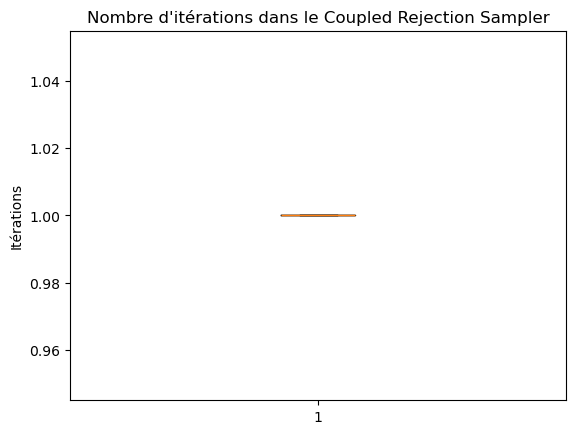

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import time

# --- Fonctions utilitaires pour les lois gaussiennes ---

def gaussian_density(x, mu, Sigma):
    """
    Calcule la densité de la loi normale multivariée en x,
    avec moyenne mu et matrice de covariance Sigma.
    """
    return multivariate_normal.pdf(x, mean=mu, cov=Sigma)

def sample_gaussian(mu, Sigma):
    """
    Tire un échantillon d'une loi normale multivariée de moyenne mu et covariance Sigma.
    """
    return np.random.multivariate_normal(mu, Sigma)

# --- Définition des lois cibles p et q ainsi que de la loi dominante γ ---

def setup_distributions(d):
    """
    Pour une dimension donnée d, on définit :
      - p = N(mu_p, Sigma_p)
      - q = N(mu_q, Sigma_q)
    On choisit une loi dominante commune γ = N(mu_γ, Sigma_γ) qui domine à la fois p et q.
    Ici, pour simplifier, on prendra :
      mu_p = 0 (vecteur nul)
      Sigma_p = I (matrice identité)
      mu_q = 0.5 (vecteur constant)
      Sigma_q = diag(linéairement croissante)
    Pour γ, on prend la moyenne moyenne et une covariance plus « large ».
    """
    mu_p = np.zeros(d)
    Sigma_p = np.eye(d)
    mu_q = 0.5 * np.ones(d)
    # Par exemple, une covariance diagonale dont les coefficients varient de 1 à 2
    Sigma_q = np.diag(np.linspace(1, 2, d))
    # Loi dominante γ : moyenne la moyenne de mu_p et mu_q,
    # et covariance égale à un multiple de l'identité, choisi suffisamment grand
    mu_gamma = 0.5 * (mu_p + mu_q)
    scale = max(np.linalg.norm(Sigma_p, 2), np.linalg.norm(Sigma_q, 2)) * 2.0
    Sigma_gamma = scale * np.eye(d)
    return mu_p, Sigma_p, mu_q, Sigma_q, mu_gamma, Sigma_gamma

# Fonctions pour calculer les densités de p, q et γ

def p_density(x, mu_p, Sigma_p):
    return gaussian_density(x, mu_p, Sigma_p)

def q_density(x, mu_q, Sigma_q):
    return gaussian_density(x, mu_q, Sigma_q)

def gamma_density(x, mu_gamma, Sigma_gamma):
    return gaussian_density(x, mu_gamma, Sigma_gamma)

# Fonctions pour tirer des échantillons selon p, q et γ

def sample_from_p(mu_p, Sigma_p):
    return sample_gaussian(mu_p, Sigma_p)

def sample_from_q(mu_q, Sigma_q):
    return sample_gaussian(mu_q, Sigma_q)

def sample_from_gamma(mu_gamma, Sigma_gamma):
    return sample_gaussian(mu_gamma, Sigma_gamma)

# --- Calcul des constantes M_p et M_q ---

def compute_M_factor(target_density, mu_target, Sigma_target, mu_gamma, Sigma_gamma):
    """
    Pour une loi cible (p ou q) et la loi dominante γ,
    la borne M est obtenue en remarquant que le rapport p(x)/γ(x)
    est maximisé en x = mu_target.
    """
    return target_density(mu_target, mu_target, Sigma_target) / gamma_density(mu_target, mu_gamma, Sigma_gamma)

def compute_M_p(mu_p, Sigma_p, mu_gamma, Sigma_gamma):
    return compute_M_factor(p_density, mu_p, Sigma_p, mu_gamma, Sigma_gamma)

def compute_M_q(mu_q, Sigma_q, mu_gamma, Sigma_gamma):
    return compute_M_factor(q_density, mu_q, Sigma_q, mu_gamma, Sigma_gamma)

# --- Implémentation du Coupled Rejection Sampler (Algorithme 1) ---

def coupled_rejection_sampler(mu_p, Sigma_p, mu_q, Sigma_q, mu_gamma, Sigma_gamma, M_p, M_q):
    """
    Cette fonction implémente l'algorithme de couplage par rejet tel que décrit dans le papier.
    On suppose ici que la loi dominante pour p et q est γ (donc p̂ = q̂ = γ).
    
    On procède ainsi :
      1. On tire (X1, Y1) à partir d'un couplage diagonal de γ.
         Ici, pour maximiser la probabilité de couplage, on prend Y1 = X1.
      2. Pour un tirage U ~ U(0,1), on accepte X1 (resp. Y1) comme échantillon de p (resp. q)
         si U < p(X1) / (M_p * γ(X1)) (resp. U < q(Y1) / (M_q * γ(Y1))).
      3. Si l'un des échantillons n'est pas accepté, on remplace par un tirage indépendant depuis p ou q.
    
    La fonction retourne le couple (X, Y) ainsi que le nombre d'itérations (le nombre de tirages depuis γ)
    réalisés dans la boucle.
    """
    iterations = 0
    while True:
        iterations += 1
        # Tirage depuis la loi dominante γ (couplage diagonal : X1 et Y1 sont identiques)
        X1 = sample_from_gamma(mu_gamma, Sigma_gamma)
        Y1 = X1  # couplage parfait pour la proposition dominante
        U = np.random.uniform()
        # Critères d'acceptation
        accept_X = (U < p_density(X1, mu_p, Sigma_p) / (M_p * gamma_density(X1, mu_gamma, Sigma_gamma)))
        accept_Y = (U < q_density(Y1, mu_q, Sigma_q) / (M_q * gamma_density(Y1, mu_gamma, Sigma_gamma)))
        # Si les deux marges sont acceptées, on renvoie X1, Y1
        if accept_X and accept_Y:
            return X1, Y1, iterations
        else:
            # Sinon, pour chaque coordonnée non acceptée, on tire indépendamment depuis la loi cible
            X_final = X1 if accept_X else sample_from_p(mu_p, Sigma_p)
            Y_final = Y1 if accept_Y else sample_from_q(mu_q, Sigma_q)
            return X_final, Y_final, iterations

# --- Implémentation de l'algorithme de Thorisson (maximal coupling) ---

def thorisson_maximal_coupling(mu_p, Sigma_p, mu_q, Sigma_q):
    """
    Implémente un algorithme de couplage maximal de Thorisson.
    
    On procède ainsi :
      1. Tirer x ~ p.
      2. Calculer la probabilité d'acceptation alpha = min{1, q(x)/p(x)}.
      3. Tirer U ~ U(0,1). Si U < alpha, alors on pose y = x (couplage réussi).
      4. Sinon, on tire y ~ q (échantillonnage indépendant).
      
    Ce mécanisme est une forme de rejet qui permet d'obtenir la probabilité maximale de couplage
    (P(X = Y) = ∫ min(p(x), q(x)) dx).
    """
    x = sample_from_p(mu_p, Sigma_p)
    ratio = q_density(x, mu_q, Sigma_q) / p_density(x, mu_p, Sigma_p)
    alpha = min(1, ratio)
    U = np.random.uniform()
    if U < alpha:
        return x, x
    else:
        y = sample_from_q(mu_q, Sigma_q)
        return x, y

# --- Fonctions d'expérimentation et affichage des résultats ---

def run_experiment(num_samples, sampler, *args):
    """
    Exécute num_samples tirages avec la fonction sampler (qui peut renvoyer un couple (X,Y) 
    et éventuellement le nombre d'itérations dans la boucle de rejet).
    Renvoie la liste des couples obtenus et, le cas échéant, la liste des itérations.
    """
    iterations_list = []
    samples = []
    for i in range(num_samples):
        result = sampler(*args)
        # Pour le coupled rejection sampler, on attend un tuple (X, Y, iterations)
        if len(result) == 3:
            x, y, iters = result
            iterations_list.append(iters)
        else:
            x, y = result
        samples.append((x, y))
    return samples, iterations_list

def main():
    # Choix de la dimension (on pourra tester pour d = 1, 5, 10, etc.)
    d = 2
    mu_p, Sigma_p, mu_q, Sigma_q, mu_gamma, Sigma_gamma = setup_distributions(d)
    
    # Calcul des constantes M (qui garantissent que p(x) <= M_p * γ(x) pour tout x, et de même pour q)
    M_p = compute_M_p(mu_p, Sigma_p, mu_gamma, Sigma_gamma)
    M_q = compute_M_q(mu_q, Sigma_q, mu_gamma, Sigma_gamma)
    print("Constantes dominantes : M_p =", M_p, "et M_q =", M_q)
    
    num_samples = 1000  # nombre de tirages pour l'expérience
    
    # Expérience avec le Coupled Rejection Sampler
    samples_cr, iters_cr = run_experiment(num_samples, coupled_rejection_sampler,
                                          mu_p, Sigma_p, mu_q, Sigma_q,
                                          mu_gamma, Sigma_gamma, M_p, M_q)
    print("Coupled Rejection Sampler – nombre moyen d’itérations :", np.mean(iters_cr))
    
    # Expérience avec l'algorithme de Thorisson
    samples_th, _ = run_experiment(num_samples, thorisson_maximal_coupling, mu_p, Sigma_p, mu_q, Sigma_q)
    
    # Estimation de la probabilité de couplage (ici, on considère X et Y « égaux » si leur différence est inférieure à une tolérance)
    tol = 1e-6
    count_cr = sum(np.all(np.abs(x - y) < tol) for x, y in samples_cr)
    coupling_prob_cr = count_cr / num_samples
    count_th = sum(np.all(np.abs(x - y) < tol) for x, y in samples_th)
    coupling_prob_th = count_th / num_samples
    
    print("Probabilité de couplage (Coupled Rejection) :", coupling_prob_cr)
    print("Probabilité de couplage (Thorisson)         :", coupling_prob_th)
    
    # Affichage d'un box-plot du nombre d'itérations (seul pour le Coupled Rejection Sampler)
    plt.figure()
    plt.boxplot(iters_cr)
    plt.title("Nombre d'itérations dans le Coupled Rejection Sampler")
    plt.ylabel("Itérations")
    plt.show()
    
if __name__ == '__main__':
    main()
